# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/MyDrive/Colab_Notebooks/mp5/assignment5")
import sys
sys.path.append(".")

Mounted at /content/drive/


In [3]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 1,280 kB in 0s (4,034 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [4]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install gym[accept-rom-license] 


     |████████████████████████████████| 1.1 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  Created wheel for ez-setup: filename=ez_setup-0.9-py3-none-any.whl size=11015 sha256=99fda3a68a6981104cc80e9eeec5a596b4a21a88ee0c568ea841c5a8d7c6e5e6
  Stored in directory: /root/.cache/pip/wheels/f4/78/bd/f88c8eddfd5a8bf2a029e5cd8bc7a9914597002b081a000ffe
Successfully built ez-setup


In [5]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.co

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [6]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [7]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()
_,_,_,info=env.step(0)

In [8]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [9]:
double_dqn = False # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

episode: 0   score: 3.0   memory length: 231   epsilon: 1.0    steps: 231    lr: 0.0001     evaluation reward: 3.0     frames: 231


KeyboardInterrupt: ignored

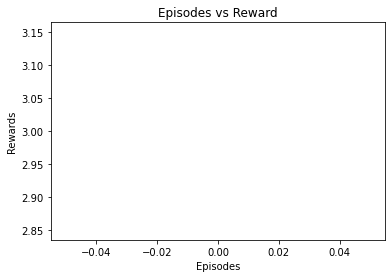

In [9]:
EPISODES=2000
rewards, episodes = [], []
best_eval_reward = 0
train_frame = 1000
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1
        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, done, info = env.step(action + 1)
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/DQN/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward),"    frames:",frame)

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/DQN/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


episode: 0   score: 3.0   memory length: 227   epsilon: 1.0    steps: 227    lr: 0.0001     evaluation reward: 3.0     frames: 227
episode: 1   score: 1.0   memory length: 379   epsilon: 1.0    steps: 152    lr: 0.0001     evaluation reward: 2.0     frames: 379
episode: 2   score: 0.0   memory length: 503   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.3333333333333333     frames: 503
episode: 3   score: 0.0   memory length: 627   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.0     frames: 627
episode: 4   score: 0.0   memory length: 750   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.8     frames: 750
episode: 5   score: 0.0   memory length: 873   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.6666666666666666     frames: 873
episode: 6   score: 2.0   memory length: 1089   epsilon: 1.0    steps: 216    lr: 0.0001     evaluation reward: 0.8571428571428571     frames: 1089
episode: 7   score: 0.0   memory len

KeyboardInterrupt: ignored

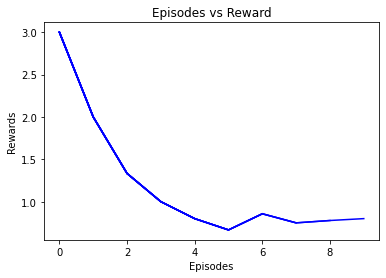

In [ ]:
double_dqn = True # set to True if using double DQN agent
rewards, episodes = [], []
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1
        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, done, info = env.step(action + 1)
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/DDQN/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward),"    frames:",frame)

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/DDQN/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)

# Creating a DQN LSTM Agent

Now we will create a DQN agent that uses LSTM rather than past frames as history. We augment the experience replay to contain previous few (state, action, reward, next state) tuples rather than just one (state, action, reward, next state) tuple so it can work with LSTMs. Use the previous tuples to generate the current hidden and context vector for LSTM. 
Esentially, when you get a sample from replay buffer during training, start with the first tuple and generate hidden and context vector from this and pass it onto the next tuple. Do so consequitively till you reach the last tuple, where you will make Q value predictions.
Training loop remains nearly the same.

In [ ]:
from agent import LSTM_Agent
agent = LSTM_Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0
train_frame = 50000
HISTORY_SIZE = 1
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives
    hidden = None

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action, hidden = agent.get_action(np.float32(history[:1, :, :]) / 255., hidden)
        state = next_state
        next_state, reward, done, info = env.step(action + 1)
        
        frame_next_state = get_frame(next_state)
        history[1, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:1, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn_lstm.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


episode: 0   score: 0.0   memory length: 124   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 0.0
episode: 1   score: 1.0   memory length: 276   epsilon: 1.0    steps: 152    lr: 0.0001     evaluation reward: 0.5
episode: 2   score: 3.0   memory length: 544   epsilon: 1.0    steps: 268    lr: 0.0001     evaluation reward: 1.3333333333333333
episode: 3   score: 1.0   memory length: 715   epsilon: 1.0    steps: 171    lr: 0.0001     evaluation reward: 1.25
episode: 4   score: 1.0   memory length: 885   epsilon: 1.0    steps: 170    lr: 0.0001     evaluation reward: 1.2
episode: 5   score: 2.0   memory length: 1084   epsilon: 1.0    steps: 199    lr: 0.0001     evaluation reward: 1.3333333333333333
episode: 6   score: 0.0   memory length: 1208   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.1428571428571428
episode: 7   score: 1.0   memory length: 1360   epsilon: 1.0    steps: 152    lr: 0.0001     evaluation reward: 1.125
episode: 8   score: 0.0   mem

/content/drive/MyDrive/Colab_Notebooks/mp5/assignment5/memory.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.array(sample)
/content/drive/MyDrive/Colab_Notebooks/mp5/assignment5/agent.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(mini_batch).transpose()


episode: 273   score: 1.0   memory length: 50045   epsilon: 0.999908920000002    steps: 152    lr: 0.0001     evaluation reward: 1.57
episode: 274   score: 0.0   memory length: 50168   epsilon: 0.9996653800000073    steps: 123    lr: 0.0001     evaluation reward: 1.56
episode: 275   score: 2.0   memory length: 50367   epsilon: 0.9992713600000158    steps: 199    lr: 0.0001     evaluation reward: 1.57
episode: 276   score: 0.0   memory length: 50490   epsilon: 0.9990278200000211    steps: 123    lr: 0.0001     evaluation reward: 1.54
episode: 277   score: 0.0   memory length: 50614   epsilon: 0.9987823000000264    steps: 124    lr: 0.0001     evaluation reward: 1.54
episode: 278   score: 3.0   memory length: 50861   epsilon: 0.998293240000037    steps: 247    lr: 0.0001     evaluation reward: 1.55
episode: 279   score: 3.0   memory length: 51107   epsilon: 0.9978061600000476    steps: 246    lr: 0.0001     evaluation reward: 1.57
episode: 280   score: 3.0   memory length: 51376   epsilo

/content/drive/MyDrive/Colab_Notebooks/mp5/assignment5/memory.py:67: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample)


episode: 285   score: 1.0   memory length: 52163   epsilon: 0.995715280000093    steps: 170    lr: 0.0001     evaluation reward: 1.51
episode: 286   score: 3.0   memory length: 52393   epsilon: 0.9952598800001029    steps: 230    lr: 0.0001     evaluation reward: 1.53
episode: 287   score: 0.0   memory length: 52517   epsilon: 0.9950143600001082    steps: 124    lr: 0.0001     evaluation reward: 1.51
episode: 288   score: 1.0   memory length: 52690   epsilon: 0.9946718200001157    steps: 173    lr: 0.0001     evaluation reward: 1.49
episode: 289   score: 1.0   memory length: 52860   epsilon: 0.994335220000123    steps: 170    lr: 0.0001     evaluation reward: 1.49
episode: 290   score: 1.0   memory length: 53030   epsilon: 0.9939986200001303    steps: 170    lr: 0.0001     evaluation reward: 1.5
episode: 291   score: 1.0   memory length: 53200   epsilon: 0.9936620200001376    steps: 170    lr: 0.0001     evaluation reward: 1.48
episode: 292   score: 2.0   memory length: 53399   epsilon

/content/drive/MyDrive/Colab_Notebooks/mp5/assignment5/agent.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  mini_batch = np.array(mini_batch).transpose()


episode: 306   score: 5.0   memory length: 56144   epsilon: 0.9878329000002641    steps: 347    lr: 0.0001     evaluation reward: 1.47
episode: 307   score: 3.0   memory length: 56372   epsilon: 0.9873814600002739    steps: 228    lr: 0.0001     evaluation reward: 1.48
episode: 308   score: 0.0   memory length: 56496   epsilon: 0.9871359400002793    steps: 124    lr: 0.0001     evaluation reward: 1.48
episode: 309   score: 3.0   memory length: 56723   epsilon: 0.986686480000289    steps: 227    lr: 0.0001     evaluation reward: 1.51
episode: 310   score: 3.0   memory length: 56969   epsilon: 0.9861994000002996    steps: 246    lr: 0.0001     evaluation reward: 1.48
episode: 311   score: 0.0   memory length: 57093   epsilon: 0.9859538800003049    steps: 124    lr: 0.0001     evaluation reward: 1.45
episode: 312   score: 1.0   memory length: 57266   epsilon: 0.9856113400003124    steps: 173    lr: 0.0001     evaluation reward: 1.46
episode: 313   score: 3.0   memory length: 57533   epsil

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [10]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_latest.pth")

In [ ]:
from gym.wrappers import Monitor # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# agent.load_policy_net("./save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['ale.lives'])
        
    life = info['ale.lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()